In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import randint, uniform
import joblib

In [ ]:
freight_data = pd.read_csv('/content/drive/MyDrive/datasets/freight_dataset.csv')

In [ ]:
freight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         32951 non-null  object 
 1   product_weight_g   32949 non-null  float64
 2   product_length_cm  32949 non-null  float64
 3   product_height_cm  32949 non-null  float64
 4   product_width_cm   32949 non-null  float64
 5   freight_value      32951 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.5+ MB


In [ ]:
freight_data.isna().sum()

product_id           0
product_weight_g     2
product_length_cm    2
product_height_cm    2
product_width_cm     2
freight_value        0
dtype: int64

In [ ]:
freight_data = freight_data.dropna()

In [ ]:
freight_data = freight_data.drop(columns=['product_id'])

In [ ]:
freight_data.head(15)

In [ ]:
# Assuming you have your data in a pandas DataFrame named 'df'
freight_data_rasa = freight_data.to_csv('/content/drive/MyDrive/Data/Modelfreight_data.csv')

In [ ]:
# Outlier Detection using IQR method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

outlier_features = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
for column in outlier_features:
    cap_outliers_iqr(freight_data, column)

# Outlier Detection at 99th Percentile of target variable (freight value)
cap_outliers_iqr(freight_data, 'freight_value')

In [ ]:
# Log transformation of skewed features
skewed_features = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

for feature in skewed_features:
    freight_data[feature] = np.log1p(freight_data[feature])

# Log transform the target variable (freight value)
freight_data['freight_value'] = np.log1p(freight_data['freight_value'])

In [ ]:
# Feature Engineering
freight_data['volume'] = freight_data['product_length_cm'] * freight_data['product_height_cm'] * freight_data['product_width_cm']
freight_data['density'] = freight_data['product_weight_g'] / freight_data['volume']

In [ ]:
freight_data.columns

In [ ]:
# Prepare features and target variable
X = freight_data[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'volume', 'density']]
y = freight_data['freight_value']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Save the scaler
#scaler_path = '/content/drive/MyDrive/Data/Model/scaler.pkl'
#joblib.dump(scaler, scaler_path)

In [ ]:
# Initialize XGBoost model
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# Define the hyperparameters distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_lambda': [0.5, 0.8, 1.0, 1.2, 1.5]
}

# Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_

# Save the best model
model_path = '/content/drive/MyDrive/Data/Model/best_xgb_model.pkl'
joblib.dump(best_xgb, model_path)

print(f"Best parameters: {random_search.best_params_}")

In [ ]:
# Evaluate the model
y_pred = best_xgb.predict(X_test)

# Reverse the log transformation for evaluation
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

#y_test_exp = y_test
#y_pred_exp = y_pred

mae = mean_absolute_error(y_test_exp, y_pred_exp)
mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp)

print(f"XGBoost MAE: {mae}")
print(f"XGBoost MAPE: {mape}")

XGBoost MAE: 4.899836667496444
XGBoost MAPE: 0.3718686698970084


In [ ]:
# k-fold cross-validation
cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')

# Convert negative MAE to positive
cv_scores = -cv_scores

print(f"Cross-Validation MAE Scores: {cv_scores}")
print(f"Mean CV MAE: {cv_scores.mean()}")
print(f"Standard Deviation CV MAE: {cv_scores.std()}")

Cross-Validation MAE Scores: [0.26539714 0.27003998 0.27004032 0.27049191 0.26827269]
Mean CV MAE: 0.26884840567461077
Standard Deviation CV MAE: 0.0018859649992576323


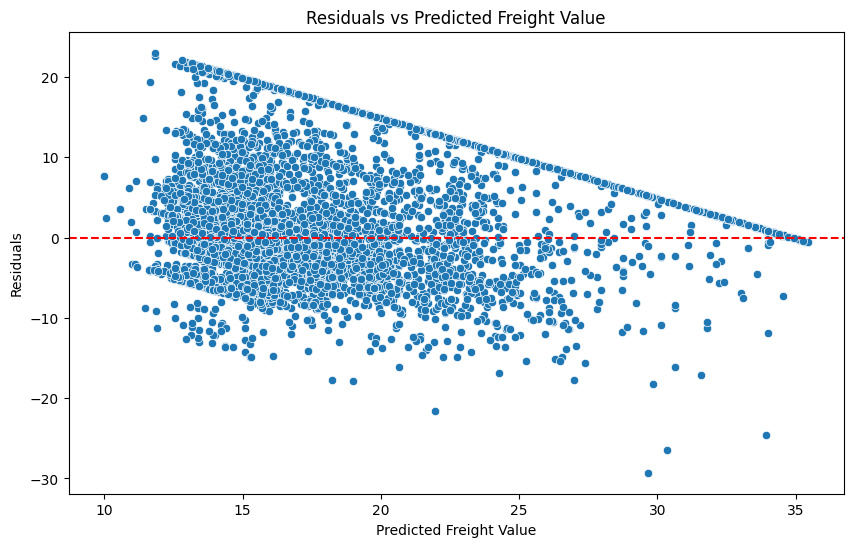

In [ ]:
# Residual plot
residuals = y_test_exp - y_pred_exp
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_exp, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Freight Value')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Freight Value')
plt.show()

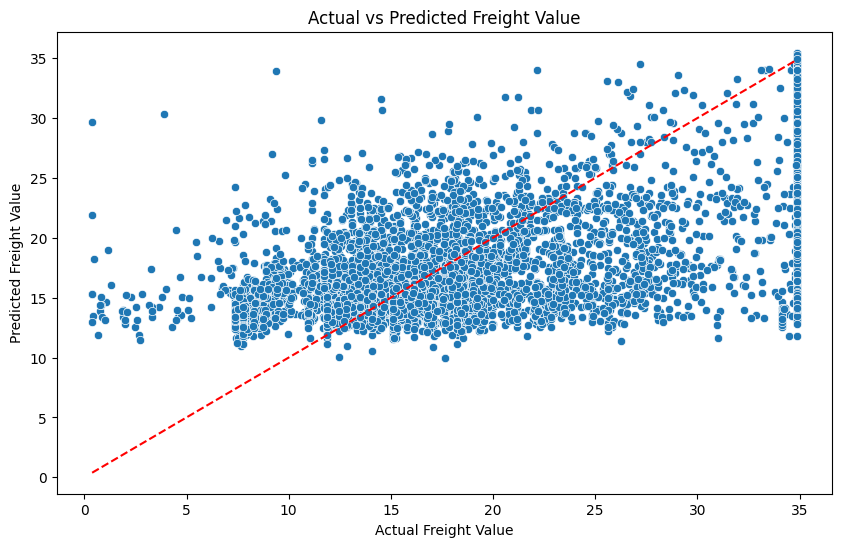

In [ ]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_exp, y=y_pred_exp)
plt.xlabel('Actual Freight Value')
plt.ylabel('Predicted Freight Value')
plt.title('Actual vs Predicted Freight Value')
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.show()

In [ ]:
# Add outlier capping to prediction function
def cap_outliers_iqr_value(value, column, df):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    if value > upper_bound:
        value = upper_bound
    if value < lower_bound:
        value = lower_bound
    return value

In [ ]:
def predict_freight_value():
    # Load the scaler and model
    scaler = joblib.load(scaler_path)
    model = joblib.load(model_path)

    # Manually input new product details
    product_weight_g = float(input("Enter product weight (g): "))
    product_length_cm = float(input("Enter product length (cm): "))
    product_height_cm = float(input("Enter product height (cm): "))
    product_width_cm = float(input("Enter product width (cm): "))

    # Cap outliers for the new input data
    product_weight_g = cap_outliers_iqr_value(product_weight_g, 'product_weight_g', freight_data)
    product_length_cm = cap_outliers_iqr_value(product_length_cm, 'product_length_cm', freight_data)
    product_height_cm = cap_outliers_iqr_value(product_height_cm, 'product_height_cm', freight_data)
    product_width_cm = cap_outliers_iqr_value(product_width_cm, 'product_width_cm', freight_data)

    # Feature engineering
    product_weight_log = np.log1p(product_weight_g)
    product_length_log = np.log1p(product_length_cm)
    product_height_log = np.log1p(product_height_cm)
    product_width_log = np.log1p(product_width_cm)
    volume = product_length_log * product_height_log * product_width_log
    density = product_weight_log / volume

    # Create a dataframe for the new data
    new_data = pd.DataFrame({
        'product_weight_g': [product_weight_log],
        'product_length_cm': [product_length_log],
        'product_height_cm': [product_height_log],
        'product_width_cm': [product_width_log],
        'volume': [volume],
        'density': [density]
    })

    # Scale the new data
    new_data_scaled = scaler.transform(new_data)

    # Predict the freight value
    freight_value_log = model.predict(new_data_scaled)
    freight_value = np.expm1(freight_value_log)

    print(f"Predicted Freight Value: {freight_value[0]}")

In [ ]:
# Call the prediction function
predict_freight_value()

Enter product weight (g): 3750
Enter product length (cm): 15
Enter product height (cm): 33
Enter product width (cm): 24
Predicted Freight Value: 14.640364646911621


In [ ]:
#0	650.0	28.0	9.0	14.0	13.29
#1	30000.0	50.0	30.0	40.0	19.93
#2	3050.0	33.0	13.0	33.0	17.87
#3	200.0	16.0	10.0	15.0	12.79
#4	3750.0	35.0	40.0	30.0	18.14
#5	468	23	18	19	8.77